### 1. Preparing our dataset


Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.

For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.

To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as danceability and acousticness on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.

Let's start by creating two pandas DataFrames out of these files that we can merge so we have features and labels (often also referred to as X and y) for the classification later on.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read in track metadata with genre labels
tracks = pd.read_csv("fma-rock-vs-hiphop.csv")
print(tracks.shape)
print(tracks.columns.tolist())

# Read in track metrics with the features
echonest_metrics = pd.read_json("echonest-metrics.json")
print(echonest_metrics.shape)
print(echonest_metrics.columns.tolist())

common_column=np.intersect1d(echonest_metrics.columns,tracks.columns)[0]

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(tracks[['track_id',"genre_top"]],echonest_metrics,on=common_column,how="inner")
print(echo_tracks.shape)

# Inspect the resultant dataframe
## missing data
print(echo_tracks.isnull().sum())
## data type
print(echo_tracks.dtypes)
## distribution of music genre
echo_tracks.genre_top.value_counts()

(17734, 21)
['track_id', 'bit_rate', 'comments', 'composer', 'date_created', 'date_recorded', 'duration', 'favorites', 'genre_top', 'genres', 'genres_all', 'information', 'interest', 'language_code', 'license', 'listens', 'lyricist', 'number', 'publisher', 'tags', 'title']
(13129, 9)
['track_id', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
(4802, 10)
track_id            0
genre_top           0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
dtype: int64
track_id              int64
genre_top            object
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
speechiness         float64
tempo               float64
valence             float64
dtype: object


Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

### 2. Pairwise relationships between continuous variables

We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:

To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).
When our datasets are very large, using fewer features can drastically speed up our computation time.
To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the pandas package.

In [69]:
# Create a correlation matrix
corr_metrics = echo_tracks.iloc[:,2:].corr()
corr_metrics.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
acousticness,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


From the above plot, there is not a much strong correlation between any of the features. So, we need not remove any feature from our data.

### 3. Features distribution
In order to build an ML model for classifying song genres, let’s take a closer look at the features histograms.

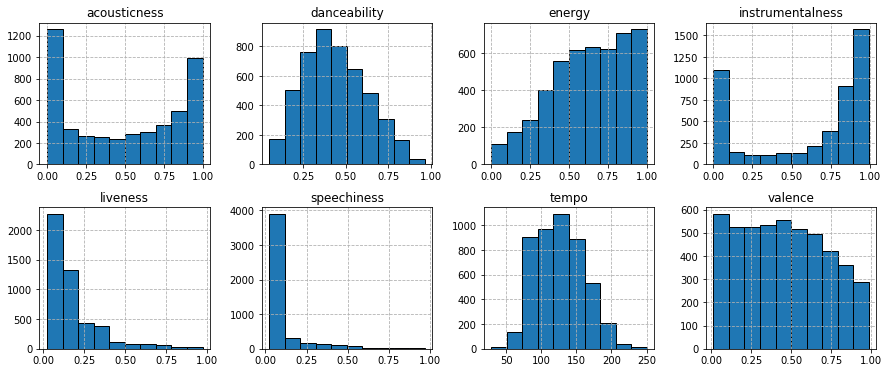

In [21]:
colNames=echo_tracks.iloc[:,2:].columns.tolist()
fig, axs = plt.subplots(2,4, figsize=(15, 6))
fig.subplots_adjust(hspace = .3, wspace=.3)

axs = axs.ravel()

for i in range(len(colNames)):
    axs[i].hist(echo_tracks[colNames[i]],edgecolor="k")
    axs[i].set_title(colNames[i])
    axs[i].grid(linestyle="--")

### 4. Normalizing the feature data
It can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).

It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler =StandardScaler()
dat=echo_tracks.drop(["track_id"],axis=1).set_index("genre_top")
colName= ["feature%s"%(i+1) for i in range(0,dat.shape[1])]
ind=dat.index
dat_scaled = scaler.fit_transform(dat)
df = pd.DataFrame(dat_scaled).set_axis(colName, axis=1,inplace=False) ## set column name
df.set_index(ind,inplace=True)
df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
genre_top,,,,,,,,
Rock,1.361706,-0.985896,1.453323,0.979975,-0.442757,-0.364157,-1.072003,-1.573102
Rock,1.312342,-0.455681,-2.463985,0.937757,-0.496436,-0.498224,-2.145066,-1.567050
Rock,1.343645,-1.604002,1.176091,0.964802,1.165836,-0.118903,-1.022854,-1.571949
Rock,1.363976,-1.147674,0.400404,-0.905888,-0.635199,-0.352735,-0.951969,-1.594372
Rock,1.085570,-0.752319,0.488500,0.841695,-0.321565,-0.110309,-0.847319,-1.424831


### 5. Principal Component Analysis on our scaled data
Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.

Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.

In [23]:
from sklearn import decomposition
pca=decomposition.PCA()
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

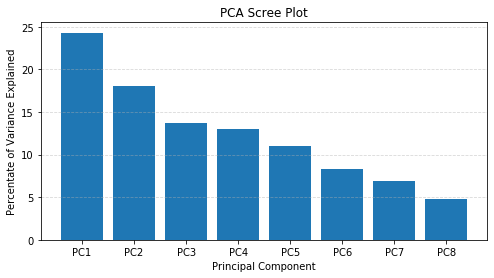

In [24]:
# plot the explained variance using a barplot
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ["PC%d"%(i+1) for i in range(0,df.shape[1])] 
plt.figure(figsize=(8, 4))
plt.bar(x= range(0,df.shape[1]), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.grid(alpha=.5,linestyle='--',axis="y")
plt.show()

### 6. Further visualization of PCA
We can also look at the cumulative explained variance plot to determine how many features are required to explain, say, about 90% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by ‘rules of thumb’). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

In [25]:
# Calculate the cumulative explained variance
print("Cumulative explained variance:")
np.cumsum(np.round(pca.explained_variance_ratio_, decimals =2))

Cumulative explained variance:


array([0.24, 0.42, 0.56, 0.69, 0.8 , 0.88, 0.95, 1.  ])

Cumulative explained variance shows that at least 6 components should be used for dimensionality reduction.

In [26]:
## Perform PCA with two components and project data onto components
pca_new=decomposition.PCA(n_components=2)
pca_new.fit(df)
df_reduced=pca_new.transform(df)
df_reduced=pd.DataFrame(df_reduced).set_index(ind)
new_df=df_reduced.reset_index()
new_df.head()

,genre_top,0,1
0,Rock,-1.985831,-0.938476
1,Rock,-0.594211,-3.653654
2,Rock,-2.262004,-0.573828
3,Rock,-1.025892,-0.906588
4,Rock,-1.432552,-1.172205


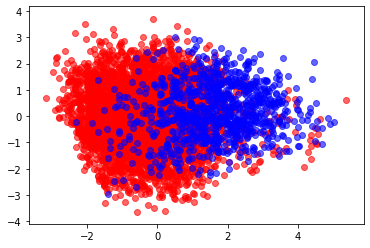

In [27]:
for x,y,g in zip(new_df[0],new_df[1],new_df["genre_top"]):
    if g=="Rock":
        plt.scatter(x,y,alpha=0.6,c="r")
    else:
        plt.scatter(x,y,alpha=0.6,c="b")


As can be seen above, using two componets can not classify appropriately two music genres. 

### 7. Train a Decision tree, Random forest, SVM, Logestic regression and KNN to classify genre

In [29]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [30]:
## Determine target and predictors 
y=df.index
X=df.reset_index(drop=True)
## Split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)


5


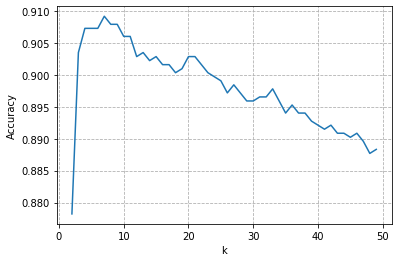

In [41]:
## finding the optimal k for KNN 
accuracy=[]
for k in range(2,50):
    # Fit Knn classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # Train the model using the training sets
    knn.fit(X_train,y_train)
    ind=accuracy_score(y_test, knn.predict(X_test))
    accuracy.append(ind)

opt_k=np.where(accuracy==np.max(accuracy))[0][0]
print(opt_k)
plt.plot(range(2,50),accuracy)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(linestyle="--");

In [42]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='linear'),
    SVC(kernel="rbf",C=1,gamma=2**-5,probability=True),
    LogisticRegression(solver='lbfgs'),
    KNeighborsClassifier(opt_k)]

classifiers_names=["Decision Tree: \n",
                   "RandomForest: \n",
                   "Support vector machine with linear kernel: \n",
                   "Support vector machine with rbf kernel: \n",
                   "Logistic Regression: \n",
                   "K Nearest Neighbors: \n"]

In [44]:
i=0
for classifier in classifiers:
    model = classifier
    model.fit(X_train,y_train)
    # print(classifier)
    class_rep = classification_report(y_test, model.predict(X_test))
    print(classifiers_names[i],class_rep)
    print("---------------------------------------------------------")
    i=i+1

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.71      0.68      0.69       309
        Rock       0.92      0.93      0.93      1276

    accuracy                           0.88      1585
   macro avg       0.82      0.81      0.81      1585
weighted avg       0.88      0.88      0.88      1585

---------------------------------------------------------
RandomForest: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.69      0.75       309
        Rock       0.93      0.96      0.94      1276

    accuracy                           0.91      1585
   macro avg       0.87      0.82      0.85      1585
weighted avg       0.91      0.91      0.91      1585

---------------------------------------------------------
Support vector machine with linear kernel: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.56      0.65       309
        Rock       0.90      0.96      0.93

All models do similarly well. However, looking at our classification report, we can see that rock song are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.
### Why might this be the case?
Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model’s ability to distinguish between classes. This also tells us that most of our model’s accuracy is driven by its ability to classify just rock songs, which is less than ideal.

### 8. Balance our data for greater performance
To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for “Rock” is not more important than a correct classification for “Hip-Hop” (and vice versa), we only need to account for differences in the sample size of our data points when weighing our classes here, and not relative importance of each class.

In [54]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks["genre_top"] == "Hip-Hop"]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = echo_tracks.loc[echo_tracks["genre_top"] == "Rock"].sample(len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

### data normalization
scaler =StandardScaler()
dat=rock_hop_bal.drop(["track_id"],axis=1).set_index("genre_top")
colName= ["feature%s"%(i+1) for i in range(0,dat.shape[1])]
ind=dat.index
dat_scaled = scaler.fit_transform(dat)
df_bal = pd.DataFrame(dat_scaled).set_axis(colName, axis=1,inplace=False) ## set column name
df_bal.set_index(ind,inplace=True)
df_bal.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
genre_top,,,,,,,,
Rock,1.042761,-1.211367,0.841999,0.830201,-0.077583,-0.625492,1.175671,0.799371
Rock,1.441337,-0.596124,0.216647,0.897551,1.092055,-0.696292,0.187806,0.794730
Rock,0.747427,-0.737183,1.485646,0.728177,-0.551839,-0.353303,0.053114,-1.133201
Rock,0.452621,-0.087696,1.359953,0.767531,-0.656800,-0.652256,0.154650,-0.902893
Rock,-1.222971,-1.302404,-0.766991,1.067543,1.675852,-0.660611,0.717225,-0.248379


In [55]:
## Redetermine target and predictors 
y=df_bal.index
X=df_bal.reset_index(drop=True)
## Redefine the train and test set from the balanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

We’ve now balanced our dataset, but in doing so, we’ve removed a lot of data points that might have been crucial to training our models. Let’s test to see if balancing our data improves model bias towards the “Rock” classification while retaining overall classification performance.

### 9. Does balancing our dataset improve model bias?
Note that we have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.

In [56]:
## finding the optimal k for KNN 
accuracy=[]
for k in range(2,50):
    # Fit Knn classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # Train the model using the training sets
    knn.fit(X_train,y_train)
    ind=accuracy_score(y_test, knn.predict(X_test))
    accuracy.append(ind)

opt_k=np.where(accuracy==np.max(accuracy))[0][0]
print(opt_k)

26


In [57]:
i=0
for classifier in classifiers:
    model = classifier
    model.fit(X_train,y_train)
    # print(classifier)
    class_rep = classification_report(y_test, model.predict(X_test))
    print(classifiers_names[i],class_rep)
    print("---------------------------------------------------------")
    i=i+1

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.84      0.82       300
        Rock       0.83      0.80      0.81       301

    accuracy                           0.82       601
   macro avg       0.82      0.82      0.82       601
weighted avg       0.82      0.82      0.82       601

---------------------------------------------------------
RandomForest: 
               precision    recall  f1-score   support

     Hip-Hop       0.91      0.89      0.90       300
        Rock       0.90      0.91      0.90       301

    accuracy                           0.90       601
   macro avg       0.90      0.90      0.90       601
weighted avg       0.90      0.90      0.90       601

---------------------------------------------------------
Support vector machine with linear kernel: 
               precision    recall  f1-score   support

     Hip-Hop       0.89      0.84      0.86       300
        Rock       0.85      0.90      0.87

Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what’s called cross-validation(CV). This step allows us to compare models in a more rigorous fashion.

### 10. Using cross-validation to evaluate our models

Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what’s known as K-fold cross-validation here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.

In [58]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [67]:
seed = 10
kfold = KFold(n_splits=10, random_state=seed)
i=0
for classifier in classifiers:
    model = classifier    
    results = cross_val_score(model, X, y, cv=kfold)
    print(" Average model score of "+classifiers_names[i]+" %.3f"%results.mean())
    print("\n")
    i+=1
    

 Average model score of Decision Tree: 
 0.819


 Average model score of RandomForest: 
 0.879


 Average model score of Support vector machine with linear kernel: 
 0.834


 Average model score of Support vector machine with rbf kernel: 
 0.841


 Average model score of Logistic Regression: 
 0.832


 Average model score of K Nearest Neighbors: 
 0.831




Source: https://www.datacamp.com/projects/449